In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os

dt.datetime.now().strftime("%Y-%m-%d %H:%M")
os.getcwd()

'/home/edmz/DisplayDataCovid/DREES_statut_vaccinal'

In [2]:
save = False

In [3]:
### functions for EDA

def input_df(fname):
    """Opens CSV file and returns a DataFrame"""
    return pd.read_csv(fname, sep = ';', parse_dates = ['date'])

def df_characteristics(df): 
    """Prints some characteristics of a pandas DataFrame"""
    lf = '\n'
    delimiter = ',    '
    if 'age' in df.columns:
        age_line = f"{len(df.age.unique())} ages:\t\t{delimiter.join(df.age.unique())}"
        multiplication_line = f"{len(df.date.unique())} * {len(df.vac_statut.unique())} * {len(df.age.unique())} = {len(df.date.unique()) * len(df.vac_statut.unique()) * len(df.age.unique())}"
    else:
        age_line = ''
        multiplication_line = f"{len(df.date.unique())} * {len(df.vac_statut.unique())} = {len(df.date.unique()) * len(df.vac_statut.unique())}"
    
    print(
        f"""
Length: {len(df)} rows,
{len(df.date.unique())} dates ranging from {min(df.date).strftime("%Y-%m-%d")} to {max(df.date).strftime("%Y-%m-%d")},
{len(df.vac_statut.unique())} status_values:\t{delimiter.join(df.vac_statut.unique())},
{age_line}
{multiplication_line}

{len(df.columns)} columns: \n{delimiter.join(df.columns)}"""
    )
        
def look_into_file(fname, nlines = 3):
    """Prints some characteristics of a df from a file of name fname (str) and a sample (nlines)"""
    df = pd.read_csv(fname, sep = ';', parse_dates = ['date'])
    print(f"""
    
*** < {fname} > ***""")
    df_characteristics(df)
    return df.sample(3)
    
def look_into_df(dfname, nlines = 3):
    """provides some characteristics from a dataframe of name dfname (str) and a sample (nlines)"""
    df = eval(dfname)
    print(f"""
    
*** < {dfname} > ***""")
    df_characteristics(df)
    return df_raw.sample(3)

def save_output(fig, dir_name, fig_name, with_date = True, with_SVG = False):
    """Saves pyplot figure (fig) as fig_name in directory dir_name. Optional date in figname. Optional SVG.
    """
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        
    now_str = dt.datetime.now().strftime("%Y-%m-%d %Hh%M ") if with_date else ''
    fname_PNG = f"{dir_name}{now_str}{fig_name}.png"
    fig.savefig(fname_PNG, bbox_inches = 'tight', pad_inches = 0.3, dpi = 150)
    
    if with_SVG:
        dir_SVG = f"{dir_name}SVG/"
        os.makedirs(dir_SVG) if not os.path.exists(dir_SVG) else None
        fname_SVG = f"{dir_SVG}{now_str} {fig_name}.svg"
        fig.savefig(fname_SVG, bbox_inches = 'tight', pad_inches = 0.3, dpi = 150)

In [4]:
fname_age = "covid-19-resultats-par-age-issus-des-appariements-entre-si-vic-si-dep-et-vac-si.csv"
fname_reg = "covid-19-resultats-regionaux-issus-des-appariements-entre-si-vic-si-dep-et-vac-si.csv"
fname_nat = "covid-19-resultats-issus-des-appariements-entre-si-vic-si-dep-et-vac-si.csv"

In [5]:
look_into_file(fname_age)


    
*** < covid-19-resultats-par-age-issus-des-appariements-entre-si-vic-si-dep-et-vac-si.csv > ***

Length: 1820 rows,
91 dates ranging from 2021-05-31 to 2021-08-29,
4 status_values:	Non-vaccinés,    Primo dose efficace,    Primo dose récente,    Vaccination complète,
5 ages:		[80;+],    [0,19],    [20,39],    [60,79],    [40,59]
91 * 4 * 5 = 1820

10 columns: 
date,    vac_statut,    age,    nb_PCR,    nb_PCR+,    HC,    HC_PCR+,    SC,    SC_PCR+,    effectif J-7


,date,vac_statut,age,nb_PCR,nb_PCR+,HC,HC_PCR+,SC,SC_PCR+,effectif J-7
1518,2021-06-05,Primo dose récente,"[40,59]",2584,62,2,2,1,1,2673252
715,2021-08-06,Non-vaccinés,"[20,39]",82132,7007,83,59,24,17,5288126
157,2021-06-09,Primo dose efficace,"[60,79]",6751,44,3,3,2,1,4454168


# Analyse des données par âge et statut vaccinal

### Functions

In [6]:
### functions for processing

def process_df(df, with_DC_with_PCR_sympt = True):
    """
    regroupe les Primo-doses
    calcule la somme des groupes d'âge ("Ensemble")
    """
    primo_vac_statut = ["Primo dose efficace", "Primo dose récente"] 
    columns_to_sum = [
        'nb_PCR', 'nb_PCR_sympt', 'nb_PCR+',
        'nb_PCR+_sympt', 'HC', 'HC_PCR+', 'SC', 'SC_PCR+', 'DC', 'DC_PCR+', 'effectif J-7',
    ] if with_DC_with_PCR_sympt else [
        'nb_PCR', 'nb_PCR+', 
        'HC', 'HC_PCR+', 'SC', 'SC_PCR+','effectif J-7',]
    
    dPrimo = df[df.vac_statut.isin(primo_vac_statut)].groupby(['date', 'age'])[columns_to_sum].sum().reset_index()
    dPrimo['vac_statut'] = 'Primo-dose'
    #dPrimo est obtenu en additionnant les valeurs de "Primo dose efficace" et "Primo dose récente"

    df = df[~df.vac_statut.isin(primo_vac_statut)]
    df = pd.concat([df, dPrimo])
    # on élimine "Primo dose efficace" et "Primo dose récente" et on ajoute 'Primo-dose'
    
    dEnsemble = df[df.vac_statut.isin(["Non-vaccinés", "Primo-dose", "Vaccination complète"])].groupby(['date', 'age'])[columns_to_sum].sum().reset_index()
    dEnsemble['vac_statut'] = 'Ensemble'
    df_merged = pd.concat([df, dEnsemble])
    
    df_merged = df_merged.sort_values(['age', 'vac_statut', 'date', ])
    df_merged = df_merged.reset_index()
    return df_merged

In [7]:
def compute_incidence(df, with_DC_with_PCR_sympt = True):
    """
    Calcule les indicateurs d'incidence
    """
    df['Effectif en Mns'] = df['effectif J-7'] / 1e6
    df['PCR_odds'] = df['nb_PCR']/df['effectif J-7'] * 1e5
    df['PCR_pos_odds'] = df['nb_PCR+']/df['effectif J-7'] * 1e5
    df['positivity'] = df['nb_PCR+']/df['nb_PCR'] * 100
    
    df['HC_odds'] = df['HC_PCR+']/df['effectif J-7'] * 1e5
    df['SC_odds'] = df['SC_PCR+']/df['effectif J-7'] * 1e5
    
    if with_DC_with_PCR_sympt: df['DC_odds'] = df['DC_PCR+']/df['effectif J-7'] * 1e5
    return df

In [8]:
def compute_vac_rate(df):
    """
    Calcule le % de vaccination dans la tranche d'âge considérée, à la date considérée
    """
    df['Taux'] = df.apply(lambda x: x['Effectif en Mns']/df[
     (df.vac_statut == 'Ensemble') & (df.age == x.age) & (df.date == x.date)]["Effectif en Mns"].unique()[0] *100, axis = 1)

In [9]:
def weekly(df, with_DC_with_PCR_sympt = True):
    columns_to_sum = [
        'nb_PCR', 'nb_PCR_sympt', 'nb_PCR+',
        'nb_PCR+_sympt', 'HC', 'HC_PCR+', 'SC', 'SC_PCR+', 'DC', 'DC_PCR+', 'effectif J-7',
    ] if with_DC_with_PCR_sympt else [
        'nb_PCR', 'nb_PCR+', 
        'HC', 'HC_PCR+', 'SC', 'SC_PCR+',]
    df[columns_to_sum]=df.rolling(window = 7, on = 'date').sum()[columns_to_sum]

### Script

In [10]:
#lire le fichier
df_raw = input_df("covid-19-resultats-par-age-issus-des-appariements-entre-si-vic-si-dep-et-vac-si.csv")

#regrouper les Primo-doses, Calculer les chiffres pour la population ensemble
df = process_df(df_raw, with_DC_with_PCR_sympt = False)

#faire la somme sur 7 jours
weekly(df, with_DC_with_PCR_sympt = False)

#calculer les indicateurs
df = compute_incidence(df, with_DC_with_PCR_sympt = False)

#calculer le taux de vaccination
compute_vac_rate(df)

#ne garder que les colonnes qui nous intéressent, à partir du 15 juin
columns_to_keep = ['date', 'vac_statut', 'age', 'Effectif en Mns', 'HC_PCR+', 'HC_odds', 'SC_PCR+', 'SC_odds', 'Taux']
df = df[columns_to_keep][df.date >= dt.datetime(2021,6,15)]

# Figures

### Functions

In [11]:
def get_value(df, label, labels):
    """gets the value of a df
    """
    conditions = [(df[k]==v) for (k, v) in labels]
    condition = np.all(conditions, axis = 0)
    values = df[condition][label].values
    n_values = len(values)
    return (f"There's one value", values[0]) if n_values == 1 else (f'There are {n_values} values !', values)

In [12]:
def last_value(df, age, status, label):
    labels = [("age", age), ("vac_statut", status), ("date", df.date.max())]
    return get_value(df, label, labels)[1]

In [13]:
def bf(text):
    return r'$\bf{' + text + '}$'

In [14]:
def bf_pc(percent):
    text = f"{percent:.1f}\%"
    return r'$\bf{' + text + '}$'

In [15]:
def figure_create():
    plt.rcParams["figure.facecolor"] = (1,1,1,1)
    fig, ax = plt.subplots(figsize = (8,4))
    return fig, ax

def figure_format(ax, ax2, ymax):
    ax.xaxis.set_tick_params(bottom = True, labelsize = 10) 
    xloc = [
        dt.datetime(2021, 6, 15),
        dt.datetime(2021, 7, 1), dt.datetime(2021, 7, 15),
        dt.datetime(2021, 8, 1), dt.datetime(2021, 8, 15), 
        dt.datetime(2021, 9, 1), dt.datetime(2021, 9, 15)]
    labels = [
        '15/06',
        '01/07', '15/07', 
        '01/08', '15/08', 
        '01/09', '15/09']
    ax.xaxis.set_ticks(xloc)
    ax.xaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_xlim(dt.datetime(2021, 6, 15), dt.datetime(2021, 9, 17))
    
    ax.set_ylabel('Hospitalisations par semaine\n(pour 100 000 habitants)')
    ax.set_ylim(0, ymax)
    
    ax2.set_ylabel('Taux de vaccination (%)')
    ax2.set_ylim(0,100)

In [16]:
def plot_pop_vaccin(df, label, title, age, save = False):
    """
    """
    df = df[df.age == age].copy()
    
    populations = ['Non-vaccinés', 'Primo-dose', 'Vaccination complète', 'Ensemble']
    colors = ['red', 'blue', 'green', 'black']
    linewidths = [1,    1,      1,   1]
    
    lns = [] #Stocke les lines
    
    fig, ax = figure_create()
    
    # Tracé des courbes pour chaque population
    for population, color, linewidth in zip(populations, colors, linewidths):  
        df_pop = df[df.vac_statut == population]
        lns += ax.plot(df_pop.date, df_pop[label], c = color, label = population, linewidth = linewidth)
    
    # Tracé de la courbe de vaccination
    ax2 = ax.twinx()
    lns += ax2.plot(df[df.vac_statut == 'Vaccination complète'].date, df[df.vac_statut == 'Vaccination complète'].Taux,
           c = 'purple', label = 'Taux de vaccination (axe de droite)', linewidth = 3)
    
    # Légende
    labs = [l.get_label() for l in lns]
    leg = plt.legend(lns, labs,  title = title, loc ='upper left', title_fontsize = 10)
    leg._legend_box.align = "left"
    
    
    # Calculs des nombres bruts de personnes
    nb_nvax = last_value(df, age, 'Non-vaccinés', label[:-4]+'PCR+')
    nb_vax = last_value(df, age, 'Vaccination complète', label[:-4]+'PCR+')
    nb_tot = last_value(df, age, 'Ensemble', label[:-4]+'PCR+')
    taux_vax_pop = last_value(df, age, 'Vaccination complète', 'Taux')
    taux_vax_concernes = nb_vax/(nb_tot)*100
    taux_nvax_pop = last_value(df, age, 'Non-vaccinés', 'Taux')
    taux_nvax_concernes = nb_nvax/(nb_tot)*100
    
    # Afficher les nombres bruts de personnes
    ax.text(dt.datetime(2021,9,1), 
            last_value(df, age, 'Non-vaccinés', label), 
            f"""{nb_nvax:.0f} personnes
non-vaccinées""")
    ax.text(dt.datetime(2021,9,1), 
            last_value(df, age, 'Vaccination complète', label), 
            f"""{nb_vax:.0f} personnes
vaccinées""")
    
    # Afficher les proportions de vaccinés dans le titre
    last_date = df.date.max().strftime('%d/%m')
    plt.title(f"""La semaine précédant le {last_date} : 
les {bf('vaccinés')} {age} représentaient {bf_pc(taux_vax_pop)} de la population et {bf_pc(taux_vax_concernes)} des hospitalisations
les {bf('non-vaccinés')} {age} représentaient {bf_pc(taux_nvax_pop)} de la population et {bf_pc(taux_nvax_concernes)} des hospitalisations""",
            loc = 'left', fontsize = 10)
    #Autres formattages
    ymax = 1.1 * df[(df.age==age)&(df.vac_statut=='Non-vaccinés')][label].max()
    figure_format(ax, ax2, ymax)
    
    #Sauvegarde
    if save: save_output(fig, './', title, with_SVG = True)

### Script

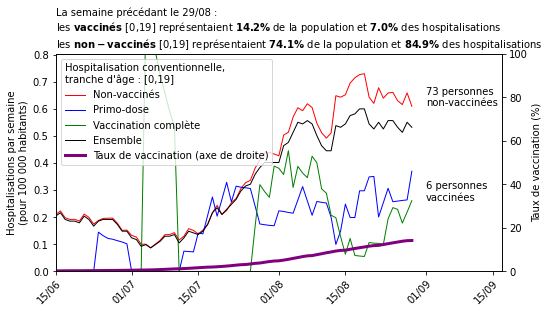

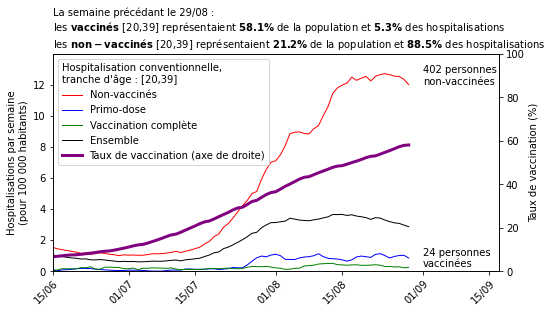

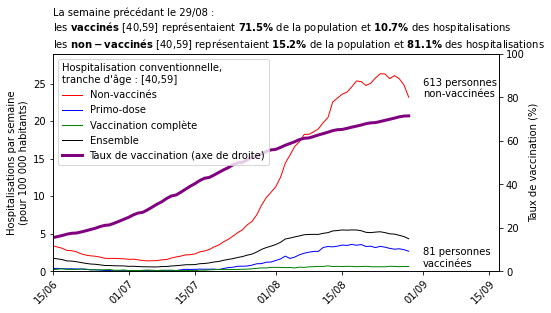

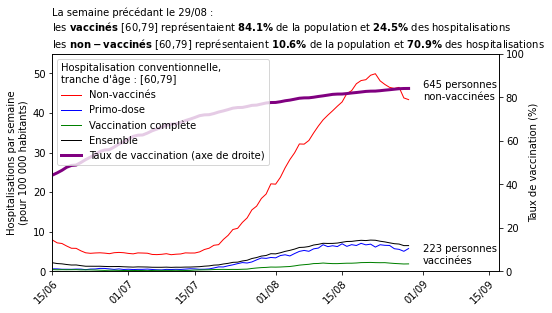

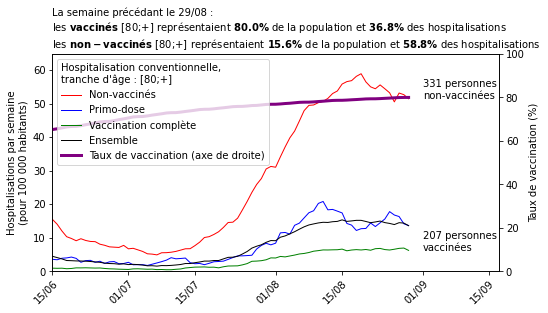

In [17]:
for age in df.age.unique():
    plot_pop_vaccin(df, 'HC_odds', f"Hospitalisation conventionnelle,\ntranche d'âge : {age}", age = age, save = save)

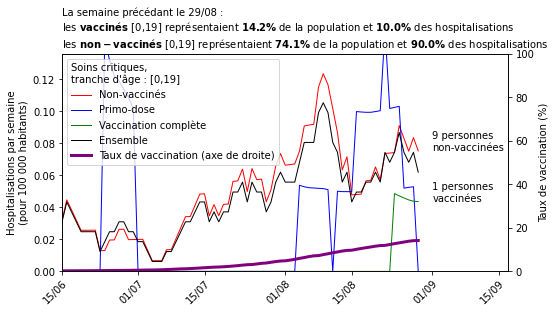

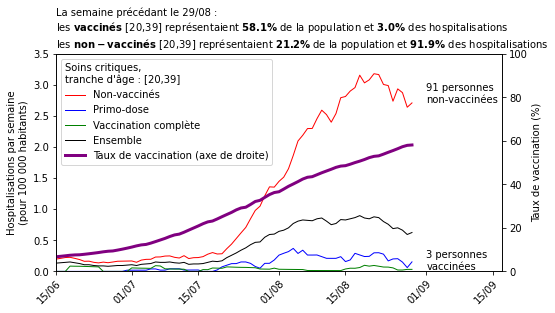

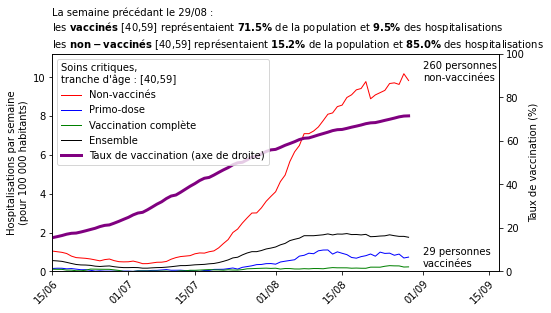

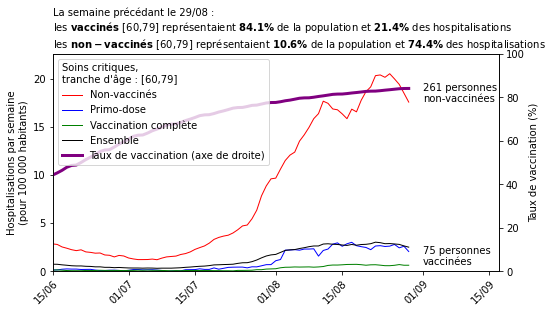

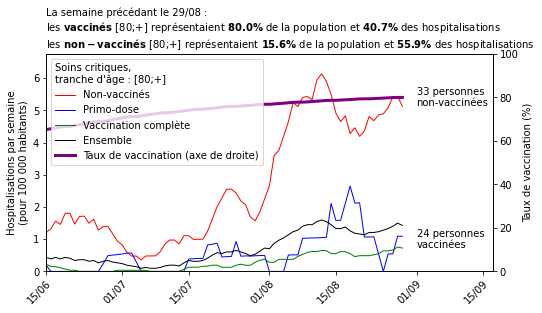

In [18]:
for age in df.age.unique():
    plot_pop_vaccin(df, 'SC_odds', f"Soins critiques,\ntranche d'âge : {age}", age = age, save = save)